In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

# for plots and aniamtions
import matplotlib.pyplot as plt
#plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (5,5)
import matplotlib.animation as animation
from IPython.display import HTML

# for the computation
import torch as th
th.manual_seed(1234)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch_dpmm.models import GaussianDPMM
import numpy as np
from tqdm import tqdm

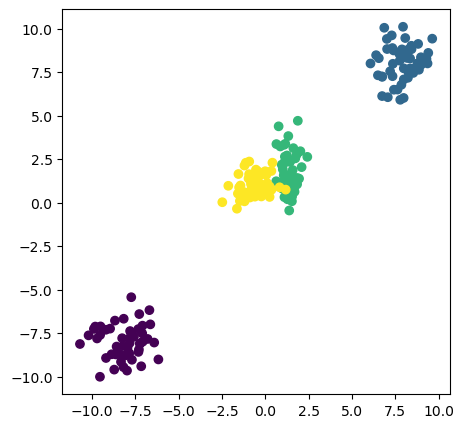

In [2]:
# create the data
num_classes = 4
D = 2

a = th.randn(D,D)
b = th.randn(D,D)

x = th.cat((MultivariateNormal(-8 * th.ones(D), th.eye(D)).sample([50]),
            MultivariateNormal(8 * th.ones(D), th.eye(D)).sample([50]),
            MultivariateNormal(th.tensor([1.5, 2]), a @ a.T).sample([50]),
            MultivariateNormal(th.tensor([-0.5, 1]), b@b.T).sample([50])))

y = th.cat((0*th.ones(50),
            1*th.ones(50),
            2*th.ones(50),
            3*th.ones(50))).to(th.int64)

#x = (x-th.mean(x, dim=0, keepdim=True)) / th.std(x, dim=0, keepdim=True)
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

## Train a Gaussina DPMM

In [3]:
# define the model
from plot_utils import plot_Gauss2D_contour
K = 20
D = 2

my_DPMM_full = GaussianDPMM(K=K, D=D, alphaDP=10, tau0=0, c0=1, n0=3*D, B0=1, is_diagonal=False)
my_DPMM_diag = GaussianDPMM(K=K, D=D, alphaDP=10, tau0=0, c0=1, n0=3*D, B0=1, is_diagonal=True)

def train_DPMM(m, title=None):
    lr = 0.8 # 0.01
    optimiser = optim.SGD(params=m.parameters(), lr=lr)

    # for the animation
    plt.ioff()
    fig, ax = plt.subplots()
    if title is not None:
        ax.set_title(title)
        
    lines_to_plot = []

    num_iterations = 50
    pbar = tqdm(range(num_iterations))
    elbo_losses = []
    for j in pbar:
        optimiser.zero_grad()
        pi, elbo_loss = m(x)
        elbo_loss.backward()
        optimiser.step()
        elbo_losses.append(elbo_loss.detach().item())

        pbar.set_postfix({'ELBO loss': elbo_loss.detach().item()})

        if j % 1 ==0:
            x_np = x.detach().numpy()
            to_plot = [ax.scatter(x_np[:, 0], x_np[:, 1], c=y.numpy(),animated=True)]
            pi, mu, Sigma = m.get_expected_params()
            pi, mu, Sigma = pi.numpy(), mu.numpy(), Sigma.numpy()
            for k in range(K):
                if pi[k]>0.05:
                    to_plot += (plot_Gauss2D_contour(mu[k], Sigma[k], ax=ax, animated=True))

            lines_to_plot.append(to_plot)
    anim = animation.ArtistAnimation(fig, lines_to_plot, repeat=True, interval=100, blit=True)
    plt.ion();
    plt.close();
    return m, anim, elbo_losses

my_DPMM_diag, anim_diag, elbo_diag = train_DPMM(my_DPMM_diag, 'Diagonal DPMM')
my_DPMM_full, anim_full, elbo_full = train_DPMM(my_DPMM_full, 'Full DPMM')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.89it/s, ELBO loss=-2.29]


In [4]:
HTML(anim_diag.to_html5_video())

In [5]:
HTML(anim_full.to_html5_video())

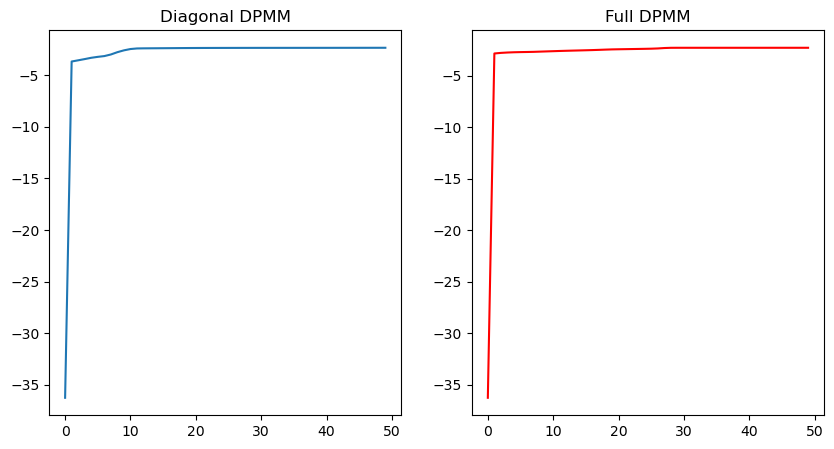

In [6]:
f, ax_list = plt.subplots(1,2, figsize=(10,5))
ax_list[0].plot(np.array(elbo_diag))
ax_list[0].set_title('Diagonal DPMM')
ax_list[1].plot(np.array(elbo_full), 'r')
ax_list[1].set_title('Full DPMM')
plt.show()